# PR8-2: Classificatiemodellen in Machine Learning.
Van Pjotr en Sennen

Hieronder is een voorbeeld uit het hoorcollege hoe we de classificatiemodellen in Machine Learning kunnen toepassen. We gaan een classificatiemodel maken met de Titanic dataset. Waar de volgende stappen in voorkomen:

Hier importeren we alle benodigde libraries en lezen we de data in.

In [1]:
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree 
from sklearn import metrics
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Laad de connnectie met de database voor later.
conn = sqlite3.connect('data/go_sales.sqlite')

Eerst gaan we alle data inlezen die nodig zijn voor deze opdracht.

In [2]:
df = pd.read_csv('data/titanic.csv')
df

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,"Zabour, Miss. Hileni",female,14.5000,1,0,2665,14.4542,NaN,C,NaN,328.0,NaN
1305,3,0,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C,NaN,NaN,NaN
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.5000,0,0,2656,7.2250,NaN,C,NaN,304.0,NaN
1307,3,0,"Zakarian, Mr. Ortin",male,27.0000,0,0,2670,7.2250,NaN,C,NaN,NaN,NaN


Hierna pakken we de data die we echt nodig hebben voor dit experiment.

In [3]:
df = df.loc[:, ['pclass', 'sex', 'age', 'survived']]
df

,pclass,sex,age,survived
0,1,female,29.0000,1
1,1,male,0.9167,1
2,1,female,2.0000,0
3,1,male,30.0000,0
4,1,female,25.0000,0
...,...,...,...,...
1304,3,female,14.5000,0
1305,3,female,NaN,0
1306,3,male,26.5000,0
1307,3,male,27.0000,0


Met de data die we nodig hebben in hand gaan we nu beginnen aan het one-hot encoden van de data.

In [4]:
df['pclass'] = df['pclass'].astype(str)
df.dtypes

pclass       object
sex          object
age         float64
survived      int64
dtype: object

Hierna pakken we de dummie data die we dan gaan gebruiken voor het trainen van het model.

In [5]:
dummies_dataframe = pd.get_dummies(df.loc[:, ['sex','pclass']])
dummies_dataframe

,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,True,False,True,False,False
1,False,True,True,False,False
2,True,False,True,False,False
3,False,True,True,False,False
4,True,False,True,False,False
...,...,...,...,...,...
1304,True,False,False,False,True
1305,True,False,False,False,True
1306,False,True,False,False,True
1307,False,True,False,False,True


Nu moeten de de dummie data nog toevoegen aan de orginele dataframe.
Dan droppen wij de sex kolom en dan pakken we de rest van de tabel mee.

In [6]:
df = pd.concat([df, dummies_dataframe], axis=1)
df = df.drop(['sex'], axis=1)
df = df.loc[:, ['pclass_1','pclass_2','pclass_3','sex_female','sex_male','age', 'survived']]
df

,pclass_1,pclass_2,pclass_3,sex_female,sex_male,age,survived
0,True,False,False,True,False,29.0000,1
1,True,False,False,False,True,0.9167,1
2,True,False,False,True,False,2.0000,0
3,True,False,False,False,True,30.0000,0
4,True,False,False,True,False,25.0000,0
...,...,...,...,...,...,...,...
1304,False,False,True,True,False,14.5000,0
1305,False,False,True,True,False,NaN,0
1306,False,False,True,False,True,26.5000,0
1307,False,False,True,False,True,27.0000,0


Hier gaan we de data opsplitsen in een train en test set. Dus verticaal opsplitsen in x en y.

In [7]:
x = df.drop('survived', axis=1)
y = df['survived']
x

,pclass_1,pclass_2,pclass_3,sex_female,sex_male,age
0,True,False,False,True,False,29.0000
1,True,False,False,False,True,0.9167
2,True,False,False,True,False,2.0000
3,True,False,False,False,True,30.0000
4,True,False,False,True,False,25.0000
...,...,...,...,...,...,...
1304,False,False,True,True,False,14.5000
1305,False,False,True,True,False,NaN
1306,False,False,True,False,True,26.5000
1307,False,False,True,False,True,27.0000


Nu gaan we de data splitsen in een train en test set. Dus horizontaal opsplitsen in x en y.

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

### Met max_depth=2
Nu gaan we de decision tree classifier en daarna opbouwen en uiteindelijk evalueren.

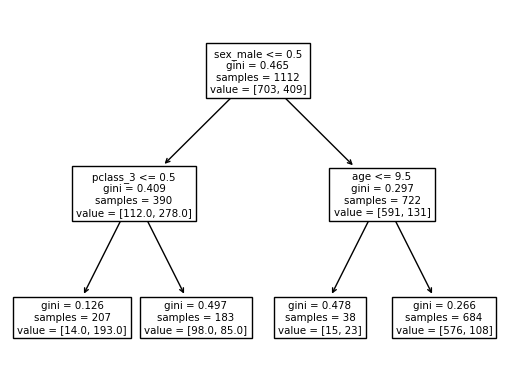

In [9]:
dtree = DecisionTreeClassifier(max_depth=2)
dtree = dtree.fit(x_train, y_train)
tree.plot_tree(dtree, feature_names=x.columns)
plt.show()

Daarna gaan we de data voorspellen en de confusion matrix maken.

In [10]:
predicted_df = pd.DataFrame(dtree.predict(x_test))
predicted_df = predicted_df.rename(columns={0: 'Predicted Survived'})
model_results_frame = pd.concat([y_test.reset_index()['survived'], predicted_df], axis=1)
model_results_frame

,survived,Predicted Survived
0,0,0
1,1,0
2,0,0
3,0,0
4,0,0
...,...,...
192,0,0
193,1,0
194,0,0
195,0,0


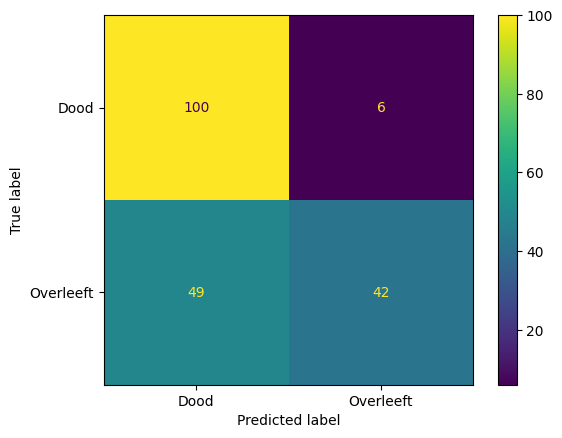

In [11]:
confusion_matrix = metrics.confusion_matrix(model_results_frame['survived'], model_results_frame['Predicted Survived'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['Dood', 'Overleeft'])

cm_display.plot()
plt.show()

Nu moeten we nog de score berekenen van de classifier.

In [12]:
metrics.accuracy_score(model_results_frame['survived'], model_results_frame['Predicted Survived'])

0.7208121827411168

### Geen max depth
Maar omdat we zojuist een decision tree classifier van een max depth van 2 hebben gemaakt, gaan we nu een classifier maken met geen max depth.

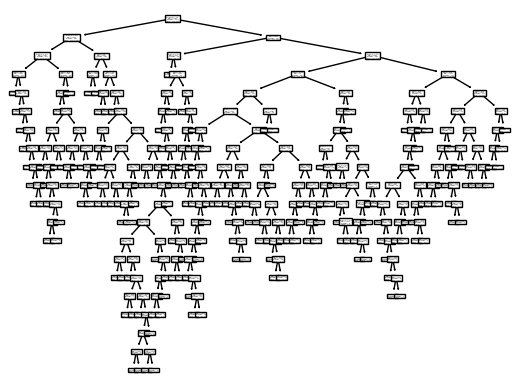

In [13]:
dtree = DecisionTreeClassifier()
dtree = dtree.fit(x_train, y_train)
tree.plot_tree(dtree, feature_names=x.columns)
plt.show()

In [14]:
predicted_df = pd.DataFrame(dtree.predict(x_test))
predicted_df = predicted_df.rename(columns={0: 'Predicted Survived'})
model_results_frame = pd.concat([y_test.reset_index()['survived'], predicted_df], axis=1)
model_results_frame

,survived,Predicted Survived
0,0,0
1,1,0
2,0,0
3,0,0
4,0,0
...,...,...
192,0,0
193,1,0
194,0,0
195,0,0


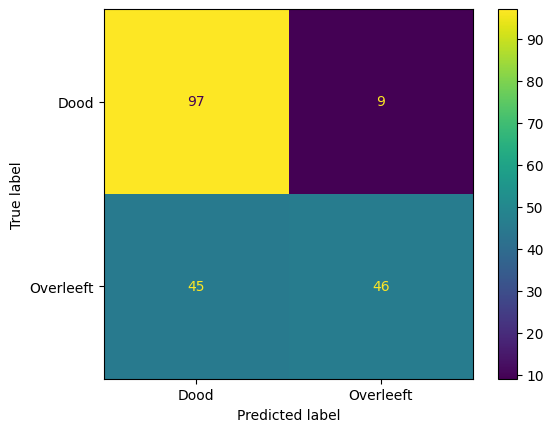

In [15]:
confusion_matrix = metrics.confusion_matrix(model_results_frame['survived'], model_results_frame['Predicted Survived'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['Dood', 'Overleeft'])

cm_display.plot()
plt.show()

In [16]:
metrics.accuracy_score(model_results_frame['survived'], model_results_frame['Predicted Survived'])

0.7258883248730964

# Nu de echte opdracht

Great Outdoors wil graag weten wat de retourredenen gaan zijn op basis van een set onafhankelijke variabelen. Daarom wil zij een model trainen op basis van reeds bekende data, zodat deze volgend jaar in gebruik kan worden genomen. Let op: de retourreden kan ook "n.v.t." zijn, niet elke order wordt namelijk geretourneerd; je zult dit moeten aanpakken door een join tussen "returned_item" en "order_details". Je doet dus het volgende met de reeds bekende data:
- Bedenk met welke onafhankelijke variabelen dit naar verwachting het beste voorspeld kan worden en zet deze samen met de afhankelijke variabele in één DataFrame.
- Pas waar nodig Dummy Encoding toe.
- Snijd dit DataFrame horizontaal en verticaal op de juiste manier.
- Train het classificatiemodel.
- Evalueer de performance van je getrainde classificatiemodel a.d.h.v. een confusion matrix.

Dit is de opdracht die we gaan uitvoeren. In dit geval gaan we de retourreden voorspellen door gebruik te maken van producten type en de prijs van het product.

In [17]:
order_details = pd.read_sql_query('SELECT * FROM order_details', conn)
returned_item = pd.read_sql_query('SELECT * FROM returned_item', conn)
returned_reason = pd.read_sql_query('SELECT * FROM return_reason', conn)
product = pd.read_sql_query("SELECT * FROM product", conn)

Tabellen gaan we nu mergen, hiervoor heb ik laatst een functie voor gemaakt om alle tabellen te mergen en kijken we alleen of de data wel van toepassing is in de tabel:

In [18]:
merged_table = pd.merge(order_details, returned_item, on='ORDER_DETAIL_CODE', how='outer')
merged_table = pd.merge(merged_table, returned_reason, on='RETURN_REASON_CODE', how='outer')
merged_table
filtered_table = merged_table.dropna()
filtered_table

,ORDER_DETAIL_CODE,ORDER_NUMBER,PRODUCT_NUMBER,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,TRIAL879,RETURN_CODE,RETURN_DATE,RETURN_REASON_CODE,RETURN_QUANTITY,TRIAL888_x,RETURN_DESCRIPTION_EN,TRIAL888_y
0,100250,9254,43,52,126.51,189.77,189.77,T,2298,14-12-2021 11:28:50,1,6,T,Defective product,T
1,100653,8483,113,36,6.01,12.05,12.05,T,2302,6-9-2021 17:43:14,1,4,T,Defective product,T
2,100698,8495,7,20,46.38,64,56.95,T,1972,4-9-2022 03:07:48,1,2,T,Defective product,T
3,100750,8498,18,40,86,129,111.8,T,1978,23-8-2022 02:04:44,1,2,T,Defective product,T
4,100835,8492,40,56,17.97,25,22.19,T,1984,15-8-2022 13:33:58,1,4,T,Defective product,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701,98314,8206,77,86,45.31,90.63,90.63,T,1961,13-7-2021 17:43:43,5,86,T,Unsatisfactory product,T
702,98631,8239,4,164,5,7,7,T,1914,15-4-2022 13:32:28,5,164,T,Unsatisfactory product,T
703,98653,8239,6,22,85.11,120,120,T,1918,25-4-2022 22:56:33,5,22,T,Unsatisfactory product,T
704,98962,8239,33,112,18,27,27,T,1932,10-4-2022 15:38:36,5,112,T,Unsatisfactory product,T


Hiernaa gaan we wat data eruit halen naast de Not A Number values. Met daarbij droppen we ook de date want die is niet van toepassing.

Daarnaast moeten we ook de TRAIL kolomen verwijderen, omdat deze niet van toepassing zijn.

In [19]:
filtered_table = filtered_table.drop(columns=["RETURN_DATE"])
print(list(filtered_table.filter(regex='TRIAL')))
filtered_table = filtered_table[filtered_table.columns.drop(list(filtered_table.filter(regex='TRIAL')))]

['TRIAL879', 'TRIAL888_x', 'TRIAL888_y']


In [20]:
selected_columns = filtered_table
selected_columns

,ORDER_DETAIL_CODE,ORDER_NUMBER,PRODUCT_NUMBER,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,RETURN_CODE,RETURN_REASON_CODE,RETURN_QUANTITY,RETURN_DESCRIPTION_EN
0,100250,9254,43,52,126.51,189.77,189.77,2298,1,6,Defective product
1,100653,8483,113,36,6.01,12.05,12.05,2302,1,4,Defective product
2,100698,8495,7,20,46.38,64,56.95,1972,1,2,Defective product
3,100750,8498,18,40,86,129,111.8,1978,1,2,Defective product
4,100835,8492,40,56,17.97,25,22.19,1984,1,4,Defective product
...,...,...,...,...,...,...,...,...,...,...,...
701,98314,8206,77,86,45.31,90.63,90.63,1961,5,86,Unsatisfactory product
702,98631,8239,4,164,5,7,7,1914,5,164,Unsatisfactory product
703,98653,8239,6,22,85.11,120,120,1918,5,22,Unsatisfactory product
704,98962,8239,33,112,18,27,27,1932,5,112,Unsatisfactory product


Hier kijken we naar welke kolommen we nodig hebben voor de voorspelling. De return_description is waarschijnlijk de kolom die we nodig hebben. Aangezien die maar een waarde heeft van 5.s

In [21]:
# We moeten controleren of er kolommen zijn die categorische variabelen bevatten die moeten worden omgezet naar dummyvariabelen.
# Laten we eerst controleren welke kolommen categorisch zijn en hoeveel unieke waarden ze bevatten.
for column in selected_columns.columns:
    if selected_columns[column].dtype == 'object':
        print(f"{column}: {selected_columns[column].nunique()} unieke waarden")

# In dit geval is de kolom RETURN_DESCRIPTION_EN categorisch.
# We passen Dummy Encoding toe op deze kolom.
dummies_dataframe = pd.get_dummies(selected_columns.loc[:, ["RETURN_DESCRIPTION_EN"]])

df = pd.concat([selected_columns, dummies_dataframe], axis=1)
df

ORDER_DETAIL_CODE: 706 unieke waarden
ORDER_NUMBER: 628 unieke waarden
PRODUCT_NUMBER: 112 unieke waarden
UNIT_COST: 231 unieke waarden
UNIT_PRICE: 232 unieke waarden
UNIT_SALE_PRICE: 423 unieke waarden
RETURN_CODE: 706 unieke waarden
RETURN_REASON_CODE: 5 unieke waarden
RETURN_QUANTITY: 66 unieke waarden
RETURN_DESCRIPTION_EN: 5 unieke waarden


,ORDER_DETAIL_CODE,ORDER_NUMBER,PRODUCT_NUMBER,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,RETURN_CODE,RETURN_REASON_CODE,RETURN_QUANTITY,RETURN_DESCRIPTION_EN,RETURN_DESCRIPTION_EN_Defective product,RETURN_DESCRIPTION_EN_Incomplete product,RETURN_DESCRIPTION_EN_Unsatisfactory product,RETURN_DESCRIPTION_EN_Wrong product ordered,RETURN_DESCRIPTION_EN_Wrong product shipped
0,100250,9254,43,52,126.51,189.77,189.77,2298,1,6,Defective product,True,False,False,False,False
1,100653,8483,113,36,6.01,12.05,12.05,2302,1,4,Defective product,True,False,False,False,False
2,100698,8495,7,20,46.38,64,56.95,1972,1,2,Defective product,True,False,False,False,False
3,100750,8498,18,40,86,129,111.8,1978,1,2,Defective product,True,False,False,False,False
4,100835,8492,40,56,17.97,25,22.19,1984,1,4,Defective product,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701,98314,8206,77,86,45.31,90.63,90.63,1961,5,86,Unsatisfactory product,False,False,True,False,False
702,98631,8239,4,164,5,7,7,1914,5,164,Unsatisfactory product,False,False,True,False,False
703,98653,8239,6,22,85.11,120,120,1918,5,22,Unsatisfactory product,False,False,True,False,False
704,98962,8239,33,112,18,27,27,1932,5,112,Unsatisfactory product,False,False,True,False,False


In [25]:
x = df.drop(columns=["RETURN_REASON_CODE", "RETURN_DESCRIPTION_EN", "RETURN_DESCRIPTION_EN_Defective product", "RETURN_DESCRIPTION_EN_Incomplete product", "RETURN_DESCRIPTION_EN_Unsatisfactory product", "RETURN_DESCRIPTION_EN_Wrong product ordered", "RETURN_DESCRIPTION_EN_Wrong product shipped"]) # Onafhankelijke variabelen
y = df[["RETURN_DESCRIPTION_EN"]] # Afhankelijke variabele
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
y

,RETURN_DESCRIPTION_EN
0,Defective product
1,Defective product
2,Defective product
3,Defective product
4,Defective product
...,...
701,Unsatisfactory product
702,Unsatisfactory product
703,Unsatisfactory product
704,Unsatisfactory product


Nu zetten we alles in een Decision Tree Classifier en gaan we de data trainen.

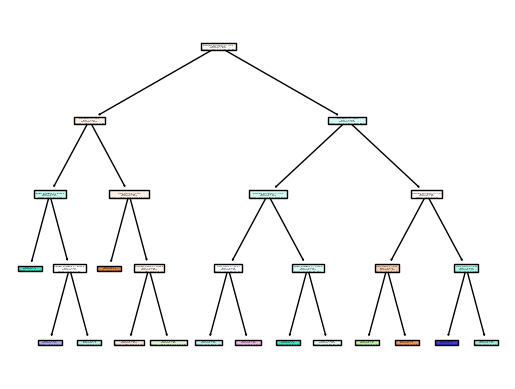

Gemiddelde kruisvalidatiescore: 0.45666666666666667
Standaarddeviatie van kruisvalidatiescores: 0.01333333333333332


In [26]:
dtree = DecisionTreeClassifier(max_depth=4, random_state=1)
dtree.fit(x_train, y_train)
tree.plot_tree(dtree, feature_names=x.columns, filled=True)
plt.show()
scores = cross_val_score(dtree, x_train, y_train, cv=5)

print("Gemiddelde kruisvalidatiescore:", scores.mean())
print("Standaarddeviatie van kruisvalidatiescores:", scores.std())

Nu gaan we voorspellingen maken en dan kijken of de data een goede score heeft. Score is 0.96, dus dat is een goede score.

In [27]:
predicted_df = pd.DataFrame(dtree.predict(x_test))
predicted_df = predicted_df.rename(columns={0: 'Predicted Return Reason'})
predicted_df

model_results_frame = pd.concat([y_test.reset_index()['RETURN_DESCRIPTION_EN'], predicted_df], axis=1)

print("Dit is de nauwkeurigheid van het model:", metrics.accuracy_score(model_results_frame['RETURN_DESCRIPTION_EN'], model_results_frame['Predicted Return Reason']))
model_results_frame

Dit is de nauwkeurigheid van het model: 0.5283018867924528


,RETURN_DESCRIPTION_EN,Predicted Return Reason
0,Wrong product ordered,Unsatisfactory product
1,Defective product,Incomplete product
2,Defective product,Defective product
3,Defective product,Defective product
4,Incomplete product,Defective product
...,...,...
101,Incomplete product,Defective product
102,Defective product,Defective product
103,Defective product,Defective product
104,Wrong product ordered,Unsatisfactory product


Nu gaan we de data in een confusion matrix zetten, waar we de prediction en de actual values in gaan zetten.

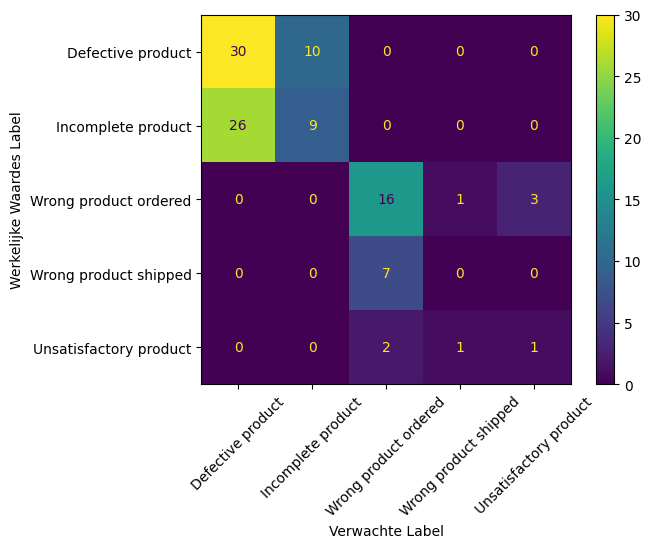

In [28]:
confusion_matrix = metrics.confusion_matrix(model_results_frame['RETURN_DESCRIPTION_EN'], model_results_frame['Predicted Return Reason'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=selected_columns['RETURN_DESCRIPTION_EN'].unique())

cm_display.plot()
plt.ylabel('Werkelijke Waardes Label')
plt.xticks(rotation=45)
plt.xlabel('Verwachte Label')
plt.show()

Nog een keer gaan we de data scoren, die zojuist in de confusion matrix is gezet. Dan gaan we kijken naar accuracy, sensitivity en specificity.

In [29]:
from sklearn.metrics import classification_report

print("Dit is de accuracy van het model:", metrics.accuracy_score(model_results_frame['RETURN_DESCRIPTION_EN'], model_results_frame['Predicted Return Reason']))
print("Dit is de sensitivity van het model:", metrics.recall_score(model_results_frame['RETURN_DESCRIPTION_EN'], model_results_frame['Predicted Return Reason'], average='weighted'))
print("Dit is de specificity van het model:", metrics.precision_score(model_results_frame['RETURN_DESCRIPTION_EN'], model_results_frame['Predicted Return Reason'], average='weighted'))

Dit is de accuracy van het model: 0.5283018867924528
Dit is de sensitivity van het model: 0.5283018867924528
Dit is de specificity van het model: 0.4887501773301178
